# Cubic Spline vs Exponentially Weighted Average

# Initial code

In [1]:
from datetime import datetime
import matplotlib.axes as axes
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline

In [2]:
c = cm.Paired.colors
date_time_parser = '%Y-%m-%d %H:%M:%S'
date_time_column ='datetime'
observed_column = 'observed'
predicted_column = 'predicted'

In [3]:
def read_csv_file(
    filename: str,
    datecolumn: str,
    datetimeparser: str,
) -> pd.DataFrame:
    df =pd.read_csv(
        filename,
        parse_dates=[datecolumn],
        date_parser=lambda s: datetime.strptime(s, datetimeparser)
    )
    return df

In [4]:
def solve_spline(
    df: pd.DataFrame,
    columnx: str,
    columny: str
) -> CubicSpline:
    '''
    Estimates the spline object for columnx, columny of a dataframe
    Requires that columnx, columny be integer or float
    Removes rows where there are missing values in columnx and columny
    Removes duplicate rows
    Sorts the dataframe by columnx in increasing order
    '''
    df = df.dropna(subset=[columnx, columny])
    df = df.sort_values(by=columnx, axis='rows', ascending=True)
    df = df.drop_duplicates(subset=columnx, keep='first')
    print('final', df.shape,
          'min', df[columny].min(),
          'max', df[columny].max())
    spline = CubicSpline(df[columnx], df[columny])
    return spline

In [5]:
def despine(ax: axes.Axes) -> None:
    '''
    Remove the top and right spines of a graph.

    There is only one x axis, on the bottom, and one y axis, on the left.
    '''
    for spine in 'right', 'top':
        ax.spines[spine].set_visible(False)

In [6]:
def plot_graph(
    df,
    columnx,
    columny,
    columnz,
    filename,
    graphname,
    graphtitle,
    graphsubtitle,
    yaxislabel,
    xaxislabel
):
    figure_width_height = (8, 6)
    fig = plt.figure(figsize=figure_width_height)
    ax = fig.add_subplot(111)
    ax.plot(df[columnx], df[columny], marker='.', linestyle='', color=c[1])
    ax.plot(df[columnx], df[columnz], marker=None, linestyle='-', color=c[5])
    ax.set_title(graphtitle + '\n' + graphsubtitle, fontweight='bold')
    ax.set_xlabel(xaxislabel, fontweight='bold')
    ax.set_ylabel(yaxislabel, fontweight='bold')
    despine(ax)
    file=filename.strip('.csv')
    ax.figure.savefig(f'{graphname}_{file}.png', format='png')

# Cubic Spline

To estimate a spline requies that the dataframe has no missing values, no duplicate rows,  and that the independent variable is sorted in increasing order.

## Example with small dataframe

In [7]:
def cs(
    filename,
    datecolumn,
    datetimeparser,
    observedcolumn,
    predictedcolumn,
    graphname
):
    df = read_csv_file(filename, datecolumn, datetimeparser)
    print('initial', df.shape,
          'min', df[observedcolumn].min(),
          'max', df[observedcolumn].max())
    # If column X of the dataframe is a datetime column, convert to numeric
    df[datecolumn] = pd.to_numeric(df[datecolumn])
    # Estimate the spline
    spline = solve_spline(df, datecolumn, observedcolumn)
    # Calculate predicted values
    df[predictedcolumn] = spline(df[datecolumn])
    # Convert the numeric datetime column to datetime64[ns]
    df[datecolumn] = df[datecolumn].astype('datetime64[ns]')
    plot_graph(
        df,
        datecolumn,
        observedcolumn,
        predictedcolumn,
        filename,
        graphname,
        'Cubic Spline Fit',
        filename,
        observedcolumn,
        datecolumn
    )

initial (14, 2) min 41.98 max 42.05
final (9, 2) min 41.98 max 42.05


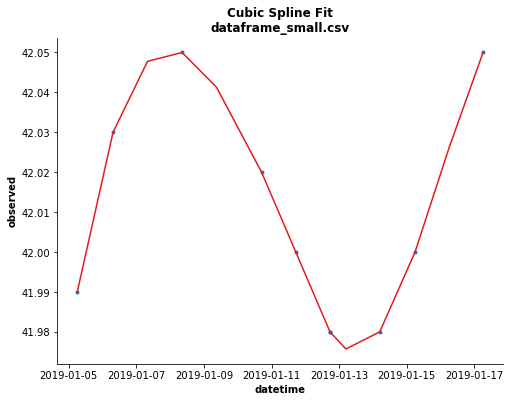

In [8]:
cs(
    'dataframe_small.csv',
    date_time_column,
    date_time_parser,
    observed_column,
    predicted_column,
    'cubic_spline'
)

## Example with large dataframe

initial (3326, 2) min 370.0 max 666.0
final (2952, 2) min 370.0 max 666.0


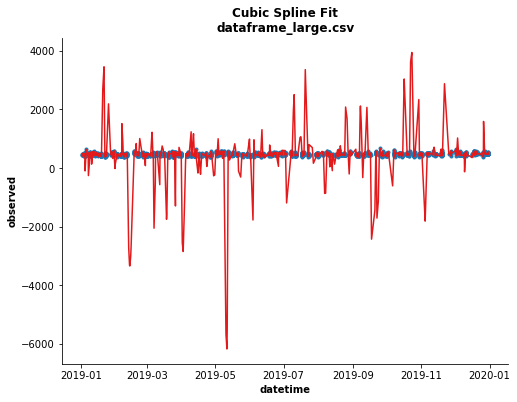

In [9]:
cs(
    'dataframe_large.csv',
    date_time_column,
    date_time_parser,
    observed_column,
    predicted_column,
    'cubic_spline'
)

initial (2958, 2) min 370 max 666
final (2952, 2) min 370 max 666


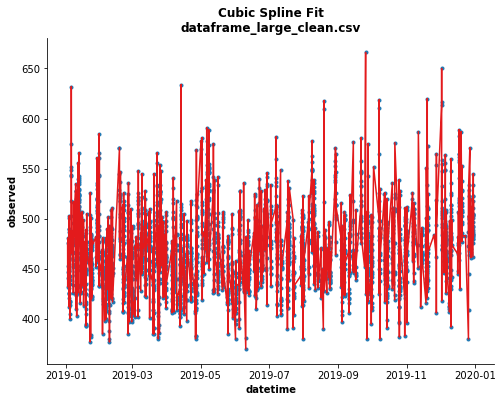

In [10]:
cs(
    'dataframe_large_clean.csv',
    date_time_column,
    date_time_parser,
    observed_column,
    predicted_column,
    'cubic_spline'
)

# Exponentially Weighted Moving Average

Exponentially Weighted Moving Average (EWMA) is also called Exponential Moving Averge (EWA). It is filter that applies weighting factors which decrease exponentially.

## Example with small dataframe

In [11]:
def ewma(
    filename,
    datecolumn,
    datetimeparser,
    observedcolumn,
    predictedcolumn,
    graphname
):
    df = read_csv_file(filename, datecolumn, datetimeparser)
    print('initial & final', df.shape,
          'min', df[observedcolumn].min(),
          'max', df[observedcolumn].max())
    # Calculate predicted values
    df[predictedcolumn] = df[observedcolumn].ewm(alpha=1).mean()    
    plot_graph(df,
               datecolumn,
               observedcolumn,
               predictedcolumn,
               filename,
               graphname,
               'Exponentially Weighted Moving Average Fit',
               filename,
               observedcolumn,
               datecolumn
    )

initial & final (14, 2) min 41.98 max 42.05


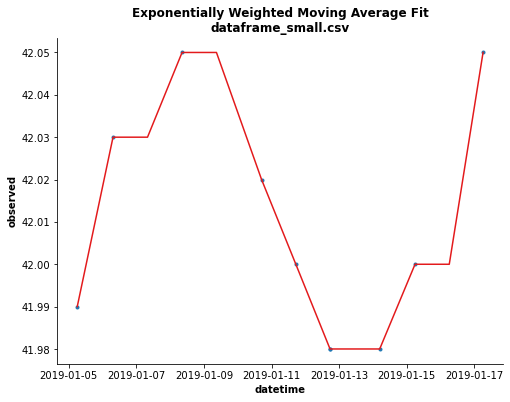

In [12]:
ewma(
    'dataframe_small.csv',
    date_time_column,
    date_time_parser,
    observed_column,
    predicted_column,
    'ewma'
)

## Example with large dataframe

initial & final (3326, 2) min 370.0 max 666.0


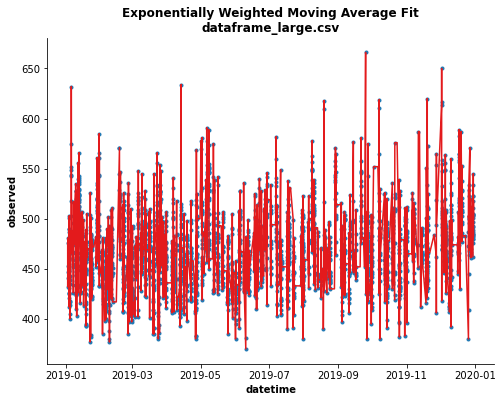

In [13]:
ewma(
    'dataframe_large.csv',
    date_time_column,
    date_time_parser,
    observed_column,
    predicted_column,
    'ewma'
)

initial & final (2958, 2) min 370 max 666


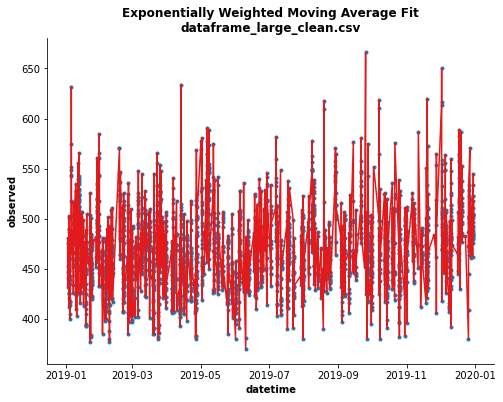

In [14]:
ewma(
    'dataframe_large_clean.csv',
    date_time_column,
    date_time_parser,
    observed_column,
    predicted_column,
    'ewma'
)

# References

[Exponential moving average](https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average)

[Exponential smoothin](https://en.wikipedia.org/wiki/Exponential_smoothing)

[Spline interpolation](https://en.wikipedia.org/wiki/Spline_interpolation)